In [1]:
from gensim import corpora, models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import EnglishStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from src.preprocessing import *
from src.feature_reduction import *
from src.classifiers import *
from src.plots import *
from src.CV import *

import time
from sklearn.svm import SVC
import pandas as pd
import matplotlib as mpl
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prepro
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
random_state=0

# Step 2

## Data loading

In [3]:
pd.set_option('display.max_colwidth',-1)
df = pd.read_json(path_or_buf='amazon_step23.json',orient='records',lines=True)

In [4]:
df.shape

(64706, 9)

In [5]:
# TODO remove sampling
# Sampling to minimze computing cost
df = df.sample(5000,random_state=random_state)
df.head()

asin  helpful  overall  \
18091  B000002NBY  [0, 0]   5         
47316  B0002ZDW80  [3, 3]   4         
44199  B0000DD79B  [2, 87]  1         
44398  B0000DFZZA  [9, 9]   4         
18616  B000002O6A  [0, 2]   4         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Pre-processing

In [6]:
a = np.array([[1, 2], [3, 4]])
print (a.shape)

(2, 2)


In [7]:
# create a corpus class with an iterator that reads one corpus document per line without loading all into memory
from gensim import corpora
from nltk.stem import WordNetLemmatizer
import enchant

eng_dic = enchant.Dict("en_US")
tester = 1
lemmatizer = WordNetLemmatizer()
#Changed the stopwords from the list of step1.
stopword_file=open('stopwords_list_step2.txt')
STOPWORDS=stopword_file.read().split()

negativeword_file=open('negative_words.txt')
NEGATIVEWORDS=negativeword_file.read().split()

positiveword_file=open('positive_words.txt')
POSITIVEWORDS=positiveword_file.read().split()

negationword_file=open('negation_words.txt')
NEGATIONWORDS=negationword_file.read().split()

#Merge both reviewText and summary
documents = df[['reviewText', 'summary']].apply(lambda x: ''.join(x), axis=1)

#print ('original: ',documents[47316], '\n')

In [8]:
#Remove special characters
documents_no_specials=remove_specials_characters(documents)
# remove stop words and tokenize
documents_no_stop= []
for document in documents_no_specials:
    new_text=[]
    for word in document.lower().split():
        if word not in STOPWORDS:
            new_text.append(word)
    documents_no_stop.append(new_text)

In [9]:
#NOT SURE IF WE NEED TO REMOVE NUMERICALS
documents_no_stop_no_numeric = remove_numerical(documents_no_stop)
#print ('remove numerics: ',documents_no_stop_no_numeric[tester], '\n')


In [10]:
# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_numeric]

#print ('lemmatize: ',documents_no_stop_no_numeric_lemmatize[tester], '\n')

In [11]:
# remove non-english words
documents_no_stop_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_numeric_lemmatize]

#print ('no english: ',documents_no_stop_no_numeric_lemmatize_english[tester], '\n')

In [12]:
df['reviewCleaned'] = [" ".join(doc) for doc in documents_no_stop_no_numeric_lemmatize_english] 

#print (df['reviewCleaned'],"\n")

In [13]:
document_neg_pos = []
for row in df['reviewCleaned']:
    review = []
    new_word = ""
    for word in row.split(" "):
        if word in NEGATIONWORDS:
            new_word = word
        if word in POSITIVEWORDS:
            if not new_word:
                review.append(word)
            else:
                new_word = new_word + word
                review.append(new_word)
                new_word = ""
        if word in NEGATIVEWORDS:
            review.append(word)
    document_neg_pos.append(review)


In [14]:
# create ready corpus
df["reviewWorded"] = [" ".join(doc) for doc in document_neg_pos]
df = df[df['reviewWorded'].map(len) > 1]
#print (df["reviewWorded"])

In [15]:
overall = df['overall'].values.tolist()

# compute values of OVERALL_BIN
OVERALL_BIN = [int(overall_value >= 5) for overall_value in overall]

# add OVERALL_BIN column to dataframe
df['OVERALL_BIN'] = OVERALL_BIN

## Vectorizing

In [16]:
vectorizer = CountVectorizer(max_df=0.4,min_df=2)

# fit vectorizer, carry out vectorization and display results
vectorizer.fit(df["reviewCleaned"])
documents_vec = vectorizer.transform(df["reviewCleaned"])
#print(documents_vec) # sparse matrix representation

In [17]:
X=documents_vec.toarray()
y=df['overall']
categories=np.unique(y)

In [18]:
# Scaling the data
X_scaled=[]
for doc in X:
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled.append(np.ravel(min_max_scaler.fit_transform(doc.reshape(-1, 1))))

/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [19]:
X_scaled[0][X_scaled[0] > 0]

array([ 0.11111111,  0.11111111,  0.11111111,  0.22222222,  0.11111111,
        0.22222222,  0.11111111,  0.11111111,  0.11111111,  0.22222222,
        0.22222222,  0.22222222,  0.11111111,  0.11111111,  0.22222222,
        0.11111111,  0.11111111,  0.11111111,  0.22222222,  0.11111111,
        0.33333333,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.22222222,  0.22222222,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.33333333,  0.11111111,  0.11111111,
        0.33333333,  0.11111111,  0.11111111,  0.22222222,  0.11111111,
        0.33333333,  0.11111111,  0.33333333,  0.11111111,  0.11111111,
        0.11111111,  0.11111111,  0.11111111,  0.22222222,  0.22222222,
        0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [21]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [22]:
#Dummy

In [23]:
start = time.time()

y_pred=[]

for i in range(X_test.shape[0]):
    y_pred.append(categories[np.random.randint(0,len(categories))])
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

accuracy: 0.207831325301
Execution time : 0.003876924514770508 seconds


In [24]:
#Cosine

In [25]:
import warnings
warnings.filterwarnings('ignore')

start= time.time()
# TODO: Optimizazion : precalculate the ref_documents
y_pred=[]

# For each element to predict
for idx,x in enumerate(X_test):
    if idx % 100 == 0:
        print(idx)
    
    best_category=""
    best_sim=0
    # for each category to check
    for cat in categories:
        # documents representing the category
        ref_docs=X_train[[y_train==cat][0]]
        # similarity between each reference document and the element
        sim=cosine_similarity(ref_docs,x)
        # If overall similarity better than best, change best
        if(np.sum(sim)/len(ref_docs)>best_sim):
            best_sim=np.sum(sim)/len(ref_docs)
            best_category=cat
    # Assign best category
    y_pred.append(best_category)
print("accuracy:",accuracy_score(y_test,y_pred))

end=time.time()
print("Execution time : {} seconds".format(end-start))

0
100
200
300
400
500
600
700
800
900
accuracy: 0.404618473896
Execution time : 1866.8426179885864 seconds


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


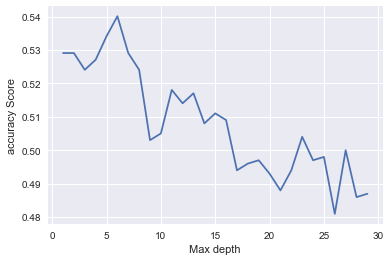

best depth= 6 with accuracy score: 0.54016064257
Execution time : 152.08951020240784 seconds


In [26]:
start=time.time()

accuracy=[]
depths=range(1,30,1)
# Check various max_depth
for max_depth in depths:
    print(max_depth)
    # fit regression model with different tree depths
    reg_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state,)
    reg_tree.fit(X_train, y_train)
    # predict a synthetic test data
    y_pred = reg_tree.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(depths,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Max depth")
plt.show()
best_depth=depths[np.argmax(accuracy)]
print("best depth=",best_depth,"with accuracy score:", np.max(accuracy))

end=time.time()
print("Execution time : {} seconds".format(end-start))

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49


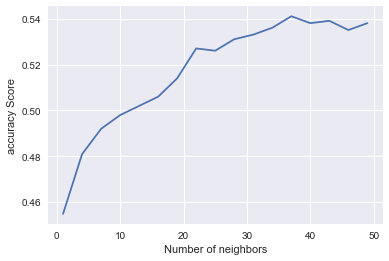

best number of neighbors= 37 with accuracy score: 0.541164658635
Execution time : 1269.6687097549438 seconds


In [27]:
start=time.time()

accuracy=[]
num_neighbors=range(1,50,3)
# Check various number neighbors
for neighbors in num_neighbors:
    print(neighbors)
    # fit regression model with different number of neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
    knn.fit(X_train, y_train)
    # predict a synthetic test data
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))

# Plot
plt.plot(num_neighbors,accuracy)
plt.ylabel("accuracy Score")
plt.xlabel("Number of neighbors")
plt.show()
best_num_neighbors=num_neighbors[np.argmax(accuracy)]
print("best number of neighbors=",best_num_neighbors,"with accuracy score:", np.max(accuracy))

end=time.time()
print("Execution time : {} seconds".format(end-start))